<a href="https://colab.research.google.com/github/rodrigogomesrc/DataScienceBES/blob/main/Agrupamentos_(2017_1_2018_1)_trancamentos_x_desempenho.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Sobre

Análise de Agrupamentos com base nas turmas do Bacharelado em Engenharia de Software (BES) da UFRN

É analisado a relação entre o desempenho e o trancamento das turmas.

O código é baseado na primeira parte da análise: o código do notebook "Análise de Turmas (2017.1 - 2018.1)" no mesmo repositório.


## Carregamento e tratamento dos dados

In [ ]:
# Importar bibliotecas e carregar os dados


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from sklearn.cluster import KMeans

#Dados Públicos da UFRN (https://dados.ufrn.br/)
matriculas_20181 = pd.read_csv("/content/matricula-componente-20181.csv", sep=";")
matriculas_20172 = pd.read_csv("/content/matricula-componente-20172.csv", sep=";")
matriculas_20171 = pd.read_csv("/content/matricula-componente-20171.csv", sep=";")

turmas_20181 = pd.read_csv("/content/turmas-2018.1.csv", sep=";")
turmas_20172 = pd.read_csv("/content/turmas-2017.2.csv", sep=";")
turmas_20171 = pd.read_csv("/content/turmas-2017.1.csv", sep=";")

data_turmas = turmas_20181.append(turmas_20172)
data_turmas = data_turmas.append(turmas_20171)

data = matriculas_20181.append(matriculas_20172)
data = data.append(matriculas_20171)

componentes = pd.read_csv("/content/componentes-curriculares-presenciais.csv", sep=";")

# Dados anonimizados fornecidos pela coordenação do Bacharelado em Engenharia de Software (BES)
bes = pd.read_csv("/content/bes.csv", sep=",")

# Estando como True retira os desistentes mantendo somente os alunos com status de "Aprovado", "Reprovado" e "Aprovado por Nota" na análise
RETIRAR_DESISTENTES = False

if(RETIRAR_DESISTENTES):
  # Separa somente os alunos não desistentes (nd)
  nd_statuses = ["APROVADO", "REPROVADO", "APROVADO POR NOTA"]
  data_nd = data[data['descricao'].isin(nd_statuses)]
  data = data_nd

# pega um dataframe com o id das turmas e componentes curriculares
turma_componente = data_turmas.filter(items=['id_turma', 'id_componente_curricular'])
turma_componente = turma_componente.rename(columns={"id_componente_curricular": "id_componente"})

# relaciona os ids das turmas com os ids e código dos componentes curriculares
componente_codigo = componentes.filter(items=['id_componente', 'codigo'])
turma_componente = turma_componente.merge(componente_codigo, on="id_componente")
turma_componente.drop_duplicates(subset="id_turma", keep="first", inplace=True)
turma_componente = turma_componente.filter(items=['id_turma', 'codigo'])

# pega os códigos de todas as turmas e separa somente os que correspondem ao BES
bes_turmas = bes['Código']
ids_turmas_bes = turma_componente[turma_componente['codigo'].isin(bes_turmas)]
ids_turmas_bes = ids_turmas_bes['id_turma']
ids_turmas_bes = ids_turmas_bes.reset_index(level=0)
ids_turmas_bes = ids_turmas_bes['id_turma']



## Preparação dos dados

In [ ]:


#pegar somente a informação se uma turma é ou não de graduação
data_turmas = data_turmas.filter(items=['id_turma', 'nivel_ensino'])

# pegar a quantidade de trancamentos por turma
qtd_trancados = data
qtd_trancados['TRANCADOS'] = [1 if valor == 'TRANCADO' else 0 for valor in qtd_trancados.descricao]
qtd_trancados.drop_duplicates(subset="discente", keep="first", inplace=True)
qtd_trancados = qtd_trancados.filter(items=['id_turma', 'TRANCADOS'])
qtd_trancados = qtd_trancados.groupby('id_turma').sum()

#Separa somente as colunas selecionadas
turma_count = data.filter(items=['id_turma', 'discente'])

'''
Remover os dados duplicados, já que cada aluno vai aparecer 3 vezes na relação entre
aluno e turma nos dados porque cada registro vai corresponder a 1 unidade. Dessa forma 
é necessário remover os duplicados para que ao contar a quantidade de alunos nas turmas
não conte o mesmo aluno mais de uma vez
'''

turma_count.drop_duplicates(subset="discente", keep="first", inplace=True)

# agrupa os dados por turma para contar quantos alunos tem em cada turma
turma_count = turma_count.groupby('id_turma').count()

# cria um dataframe só com a turma e a média final de cada aluno naquela turma
media_turma = data.filter(items=['id_turma', 'media_final'])
media_turma = media_turma.dropna()

#troca a vírgula por ponto nos valores numéricos e converte para float para permitir o cálculo
media_turma['media_final'] = media_turma['media_final'].str.replace(',', '.')
media_turma['media_final'] = pd.to_numeric(media_turma['media_final'], downcast='float')

#faz a média das médias finais de todos os alunos de uma turma, calculando a média geral da turma
media_turma = media_turma.groupby('id_turma').mean()

# junta os dataframes da média da turma com o dataframe com a quantidade de alunos
df = pd.merge(turma_count, media_turma, right_index=True, left_index=True)
df = df.rename(columns={"discente": "QTD_ALUNOS", "media_final": "MEDIA_FINAL"})

# junta a quantidade de trancados na turma
df = pd.merge(df, qtd_trancados, right_index=True, left_index=True)

# Separa somente os dados de graduação
grad = df.reset_index(level=0)
grad = grad.merge(data_turmas, on="id_turma", how="left")
grad.drop_duplicates(subset="id_turma", keep="first", inplace=True)
grad = grad[grad['nivel_ensino'] == "GRADUAÇÃO"]
grad = grad.rename(columns={'id_turma': 'TURMA'})
grad = grad.filter(items=['TURMA', 'QTD_ALUNOS', 'MEDIA_FINAL', 'TRANCADOS'])

# Separando somente as turmas do BES
bes_df = grad[grad['TURMA'].isin(ids_turmas_bes)]


## Preparação dos dados para gerar os gráficos


In [ ]:
# pega todas as turmas com a mesma quantidade de alunos e faz uma média
'''
Faz a média da média final de cada turma com a mesma quantidade de alunos, para
diminuir a quantidade de pontos no scatter plot
'''

qtd = grad.filter(items=['QTD_ALUNOS', 'MEDIA_FINAL', 'TRANCADOS'])

# pega a quantidade de turmas com n quantidade de alunos
sizes = qtd.copy()
sizes['QTD_TURMAS'] = 1
sizes = sizes.groupby('QTD_ALUNOS').count()
sizes = sizes.filter(items=['QTD_ALUNOS', 'QTD_TURMAS'])

qtd = qtd.groupby('QTD_ALUNOS').mean()
qtd.reset_index(level=0, inplace=True)
qtd['PORCENTAGEM_TRANCAMENTOS'] = (qtd['TRANCADOS'] / qtd['QTD_ALUNOS']) * 100
qtd = qtd.merge(sizes, on="QTD_ALUNOS")

#somente as turmas do BES
qtd_bes = bes_df.filter(items=['TURMA', 'QTD_ALUNOS', 'MEDIA_FINAL', 'TRANCADOS'])

# pega a quantidade de turmas com n quantidade de alunos

sizes = qtd_bes.copy()
sizes = sizes.groupby('QTD_ALUNOS').count()
sizes = sizes.filter(items=['QTD_ALUNOS', 'QTD_TURMAS'])

qtd_bes['PORCENTAGEM_TRANCAMENTOS'] = (qtd_bes['TRANCADOS'] / qtd_bes['QTD_ALUNOS']) * 100
qtd_bes = qtd_bes.merge(sizes, on="QTD_ALUNOS")


"\n# Dados desempenho por notas\nx = qtd['QTD_ALUNOS'].to_numpy()\ny = qtd['MEDIA_FINAL'].to_numpy()\nqtd_turmas = qtd['QTD_TURMAS'].to_numpy()\n\nx_bes = qtd_bes['QTD_ALUNOS'].to_numpy()\ny_bes = qtd_bes['MEDIA_FINAL'].to_numpy()\nqtd_turmas_bes = qtd_bes['QTD_TURMAS'].to_numpy()\n\n# Dados desempenho por trancamentos\nx_tranc_grad = qtd['QTD_ALUNOS'].to_numpy()\ny_tranc_grad = qtd['PORCENTAGEM_TRANCAMENTOS'].to_numpy()\n\nx_tranc_bes = qtd_bes['QTD_ALUNOS'].to_numpy()\ny_tranc_bes = qtd_bes['PORCENTAGEM_TRANCAMENTOS'].to_numpy()\n"

## Gráficos

**Gráfico com relação entre trancamentos e desempenho (normalizado e sem agrupamento)**


    MEDIA_FINAL  PORCENTAGEM_TRANCAMENTOS
4         0.710                   0.43855
15        0.720                   0.43855
24        0.355                   0.43855
27        0.930                   0.43855
31        0.940                   0.43855


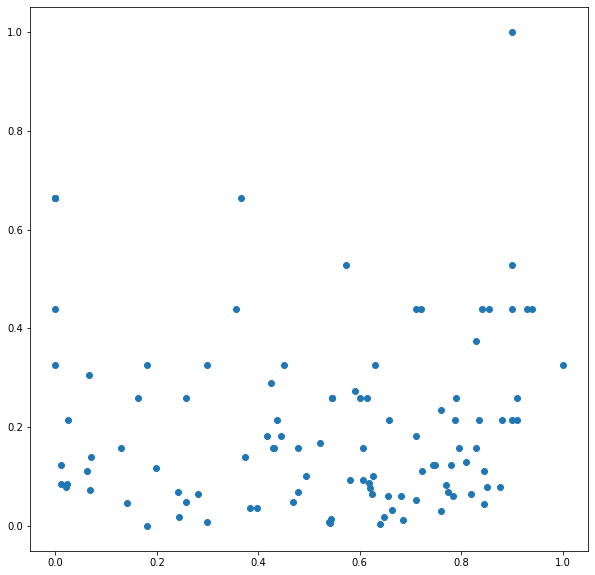

In [ ]:

bes_data_with_clusters = qtd_bes.copy()

cluster_data = qtd_bes.filter(items=['MEDIA_FINAL', 'PORCENTAGEM_TRANCAMENTOS'])

cluster_data = cluster_data[cluster_data['PORCENTAGEM_TRANCAMENTOS'] > 0]

max_trancamentos = cluster_data['PORCENTAGEM_TRANCAMENTOS'].max()
min_trancamentos = cluster_data['PORCENTAGEM_TRANCAMENTOS'].min()
range_trancamentos = max_trancamentos - min_trancamentos

max_media = cluster_data['MEDIA_FINAL'].max()
min_media = cluster_data['MEDIA_FINAL'].min()
range_media = max_media - min_media

# Faz a normalização
cluster_data['PORCENTAGEM_TRANCAMENTOS'] = (cluster_data['PORCENTAGEM_TRANCAMENTOS'] - min_trancamentos)/ range_trancamentos
cluster_data['MEDIA_FINAL'] = (cluster_data['MEDIA_FINAL'] - min_media) / range_media

fig = plt.figure(figsize=(10,10))
plt.scatter(x = 'MEDIA_FINAL', y = 'PORCENTAGEM_TRANCAMENTOS', data=cluster_data)

**Usando o método do cotovelo para tentar determinar o número ideal de grupos**

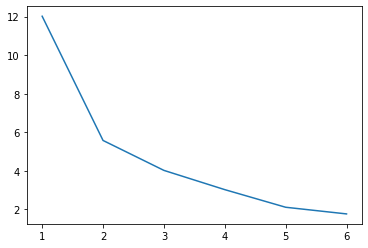

In [ ]:
wcss = []

for i in range (1,7):
  kmeans = KMeans(i)
  kmeans.fit(cluster_data)
  wcss_iter = kmeans.inertia_
  wcss.append(wcss_iter)

number_clusters = range(1,7)
plt.plot(number_clusters, wcss)



**Agrupamento**

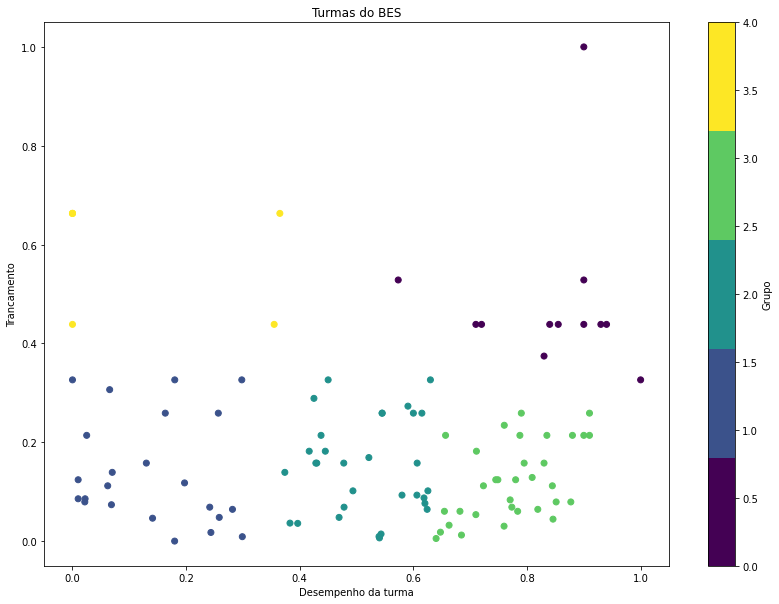

In [ ]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

k = KMeans(5)
k.fit(cluster_data)
clusters = k.fit_predict(cluster_data)

cluster_data['CLUSTER'] = clusters

colormap = cm.get_cmap('viridis', 5)

plt.scatter(x = 'MEDIA_FINAL', y = 'PORCENTAGEM_TRANCAMENTOS', data=cluster_data, c=cluster_data['CLUSTER'],  cmap=colormap)
plt.clim(0,4)
cbar = plt.colorbar()
cbar.set_label('Grupo')

plt.title('Turmas do BES')
plt.xlabel('Desempenho da turma')
plt.ylabel('Trancamento')


plt.rcParams['figure.figsize'] = [14, 10]
plt.savefig('plot_agrupamentos.jpg')
plt.show()



In [ ]:
# Baixar o agrupamento

files.download('plot_agrupamentos.jpg')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Listagem das matérias de cada grupo

**Separando disciplinas por grupo**

In [ ]:

bes_data_with_clusters = bes_data_with_clusters[bes_data_with_clusters['PORCENTAGEM_TRANCAMENTOS'] > 0]
bes_data_with_clusters['CLUSTER'] = cluster_data['CLUSTER']

tc = turma_componente.copy()
tc = tc.rename(columns={"id_turma": "TURMA", "codigo": "CODIGO"})

tc = tc.merge(bes_data_with_clusters, on="TURMA")

tc_id = tc.filter(items=['TURMA', 'CODIGO', 'CLUSTER'])

names = componentes.filter(items=['codigo', 'nome'])
names = names.rename(columns={'codigo': 'CODIGO', 'nome': 'NOME'})

tc_id = tc_id.merge(names, on='CODIGO')
tc_id = tc_id.filter(items=['CODIGO', 'NOME', 'CLUSTER'])

cluster0 = tc_id[tc_id['CLUSTER'] == 0]
cluster1 = tc_id[tc_id['CLUSTER'] == 1]
cluster2 = tc_id[tc_id['CLUSTER'] == 2]
cluster3 = tc_id[tc_id['CLUSTER'] == 3]
cluster4 = tc_id[tc_id['CLUSTER'] == 4]


**Grupo 0**

In [ ]:
cluster0

,CODIGO,NOME,CLUSTER
6,DEF0651,"ATIVIDADE FISICA, LAZER E CULTURA",0
7,DEF0040,TECNICAS DE DANCA,0
8,DEF0049,METODOLOGIA DO JUDO,0
9,DEF0055,METODOLOGIA DA IOGA,0
21,DIM0095,TOPICOS ESPECIAIS EM COMPUTACAO VI,0
51,ICE1025,NEUROCIÊNCIA BÁSICA NO PROCESSO DE APRENDIZAGEM,0
58,ADM0523,EMPREENDEDORISMO E PLANO DE NEGÓCIOS,0
61,ADM0079,EMPREENDEDORISMO,0
69,FPE0087,LÍNGUA BRASILEIRA DE SINAIS - LIBRAS,0
75,DAT0101,EXPRESSAO VISUAL I,0


** Grupo 1**

In [ ]:
cluster1

,CODIGO,NOME,CLUSTER
2,DEF0651,"ATIVIDADE FISICA, LAZER E CULTURA",1
3,DEF0651,"ATIVIDADE FISICA, LAZER E CULTURA",1
4,DEF0651,"ATIVIDADE FISICA, LAZER E CULTURA",1
5,DEF0651,"ATIVIDADE FISICA, LAZER E CULTURA",1
13,DEF0062,CONSCIENCIA CORPORAL,1
14,DEF0062,CONSCIENCIA CORPORAL,1
15,LET0568,LÍNGUA BRASILEIRA DE SINAIS - LIBRAS,1
17,LET0568,LÍNGUA BRASILEIRA DE SINAIS - LIBRAS,1
18,DIM0123,PENSAMENTO COMPUTACIONAL,1
20,DIM0537,TÓPICOS ESPECIAIS EM ENGENHARIA DE SOFTWARE VII,1


**Grupo 2**

In [ ]:
cluster2

,CODIGO,NOME,CLUSTER
1,DEF0650,"ATIVIDADE FISICA, SAUDE E QUALIDADE DE VIDA",2
16,LET0568,LÍNGUA BRASILEIRA DE SINAIS - LIBRAS,2
22,DIM0538,TÓPICOS ESPECIAIS EM ENGENHARIA DE SOFTWARE VIII,2
23,DIM0097,TOPICOS ESPECIAIS EM COMPUTACAO VIII,2
24,DIM0320,ALGORITMO E PROGRAMACAO DE COMPUTADORES,2
27,PSI7033,INTRODUÇÃO AOS PROCESSOS PSICOSSOCIOLÓGICOS E ...,2
28,MAT0311,MATEMATICA PARA ENGENHARIA I,2
29,MAT0318,CALCULO BASICO I,2
32,MAT0345,CALCULO DIFERENCIAL E INTEGRAL I,2
37,LEM2020,INGLÊS PARA FINS ACADÊMICOS I,2


**Grupo 3**

In [ ]:
cluster3

,CODIGO,NOME,CLUSTER
11,FIL0605,HISTORIA DA FILOSOFIA I,3
19,DIM0549,GRAFOS,3
25,DIM0320,ALGORITMO E PROGRAMACAO DE COMPUTADORES,3
26,DIM0320,ALGORITMO E PROGRAMACAO DE COMPUTADORES,3
30,MAT0319,ALGEBRA LINEAR BASICA I,3
31,MAT0345,CALCULO DIFERENCIAL E INTEGRAL I,3
33,MAT0345,CALCULO DIFERENCIAL E INTEGRAL I,3
39,ARQ0515,METODOS E TECNICAS,3
41,ECT2106,"CIÊNCIA, TECNOLOGIA E SOCIEDADE",3
42,ECT2102,VETORES E GEOMETRIA ANALÍTICA,3


**Grupo 4**

In [ ]:
cluster4

,CODIGO,NOME,CLUSTER
0,DEF0650,"ATIVIDADE FISICA, SAUDE E QUALIDADE DE VIDA",4
10,COM0152,SONOPLASTIA,4
12,LET0196,FUNDAMENTOS DA LITERATURA OCIDENTAL I,4
49,ECT2306,MEIO AMBIENTE E DESENVOLVIMENTO URBANO,4
77,ECO0311,ECONOMIA PARA ENGENHARIA,4
87,IMD0027,PROGRAMAÇÃO ORIENTADA A OBJETOS,4
88,IMD0027,PRÁTICAS DE LEITURA E ESCRITA EM PORTUGUÊS II,4
